<a href="https://colab.research.google.com/github/teszc/AMD_similar_reviews/blob/main/AMD1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasketch tqdm

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.7 MB/s eta 0:00:00


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"tszca16","key":"1d8bbc858a44599970c7579fe1acc92b"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip amazon-books-reviews.zip


Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.05G/1.06G [00:05<00:00, 298MB/s]
100% 1.06G/1.06G [00:05<00:00, 224MB/s]
Archive:  amazon-books-reviews.zip
  inflating: Books_rating.csv        
  inflating: books_data.csv          


In [4]:
#load dataset
df = pd.read_csv('Books_rating.csv')

#examine data
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nSample reviews:")
print(df['review/text'].head())

#check for missing values
missing_reviews = df['review/text'].isnull().sum()
print(f"\nMissing reviews: {missing_reviews} ({missing_reviews/len(df):.2%})")

Dataset shape: (3000000, 10)
Columns: ['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness', 'review/score', 'review/time', 'review/summary', 'review/text']

Sample reviews:
0    This is only for Julie Strain fans. It's a col...
1    I don't care much for Dr. Seuss but after read...
2    If people become the books they read and if "t...
3    Theodore Seuss Geisel (1904-1991), aka &quot;D...
4    Philip Nel - Dr. Seuss: American IconThis is b...
Name: review/text, dtype: object

Missing reviews: 8 (0.00%)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Dataset is large, creating a sample...
New sample shape: (100000, 10)
Preprocessing reviews...


  0%|          | 0/100000 [00:00<?, ?it/s]


Token count statistics:
Min: 1
Max: 2662
Mean: 73.0
Median: 46.0


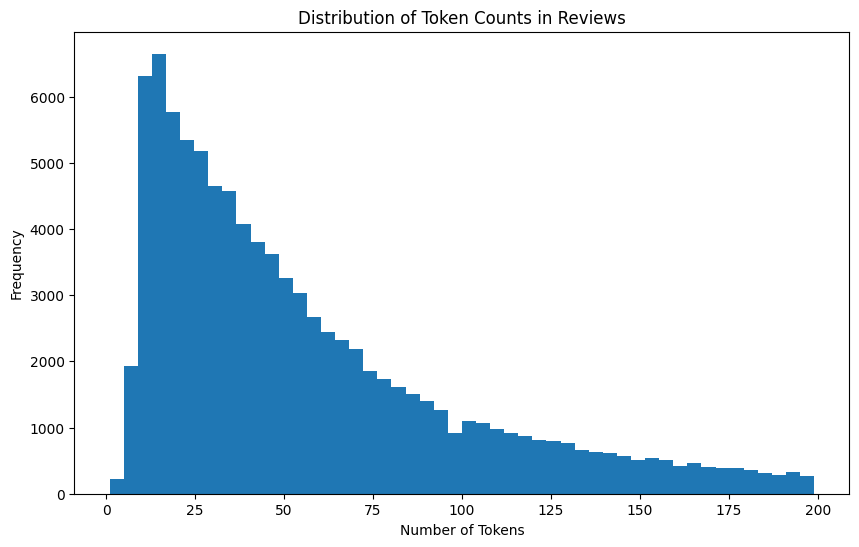

In [5]:
import nltk
nltk.download('punkt_tab')

def preprocess_text(text):
    if isinstance(text, str):
        #convert to lowercase
        text = text.lower()
        #remove punctuation and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        #tokenize
        tokens = word_tokenize(text)
        #remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        return tokens
    return []

#create a sample since the dataset is very large
#adjust the sample size based on your available RAM
if len(df) > 100000:
    print("Dataset is large, creating a sample...")
    df = df.sample(100000, random_state=42)
    print(f"New sample shape: {df.shape}")

#apply preprocessing with progress bar
print("Preprocessing reviews...")
df['processed_tokens'] = [preprocess_text(text) for text in tqdm(df['review/text'])]

#convert tokens to sets for Jaccard similarity calculation
df['token_set'] = df['processed_tokens'].apply(set)

#show statistics about token counts
token_counts = df['processed_tokens'].apply(len)
print(f"\nToken count statistics:")
print(f"Min: {token_counts.min()}")
print(f"Max: {token_counts.max()}")
print(f"Mean: {token_counts.mean():.1f}")
print(f"Median: {token_counts.median()}")

#visualize token count distribution
plt.figure(figsize=(10, 6))
plt.hist(token_counts[token_counts < 200], bins=50)  # Filter very long reviews for better visualization
plt.title('Distribution of Token Counts in Reviews')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [6]:
from datasketch import MinHash, MinHashLSH

#parameters
similarity_threshold = 0.5
num_perm = 128  # Number of permutations for MinHash

#function to calculate actual Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

#create a smaller sample for demonstration if needed
sample_size = min(20000, len(df))  # Adjust based on available memory
df_sample = df.sample(sample_size, random_state=42)
print(f"Creating MinHash for {len(df_sample)} reviews...")

#create MinHash objects
minhashes = {}
for idx, row in tqdm(df_sample.iterrows()):
    tokens = row['processed_tokens']
    if len(tokens) > 5:  # Skip very short reviews
        m = MinHash(num_perm=num_perm)
        for token in tokens:
            m.update(token.encode('utf-8'))
        minhashes[idx] = m

print(f"Created {len(minhashes)} MinHash objects")

#create LSH index
lsh = MinHashLSH(threshold=similarity_threshold, num_perm=num_perm)

#add minhashes to LSH index
print("Building LSH index...")
for idx, minhash in tqdm(minhashes.items()):
    lsh.insert(idx, minhash)

#find similar pairs using LSH
print("Finding similar reviews...")
similar_reviews = []
for idx, minhash in tqdm(minhashes.items()):
    neighbors = lsh.query(minhash)
    for neighbor in neighbors:
        if neighbor > idx:  #avoid duplicates
            #calculate actual Jaccard similarity
            set1 = df_sample.loc[idx]['token_set']
            set2 = df_sample.loc[neighbor]['token_set']
            similarity = jaccard_similarity(set1, set2)

            if similarity >= similarity_threshold:
                similar_reviews.append({
                    'review1_id': idx,
                    'review2_id': neighbor,
                    'similarity': similarity
                })

#convert to df for easier analysis
similar_reviews_df = pd.DataFrame(similar_reviews)
print(f"Found {len(similar_reviews_df)} similar review pairs")

Creating MinHash for 20000 reviews...


0it [00:00, ?it/s]

Created 19913 MinHash objects
Building LSH index...


  0%|          | 0/19913 [00:00<?, ?it/s]

Finding similar reviews...


  0%|          | 0/19913 [00:00<?, ?it/s]

Found 169 similar review pairs


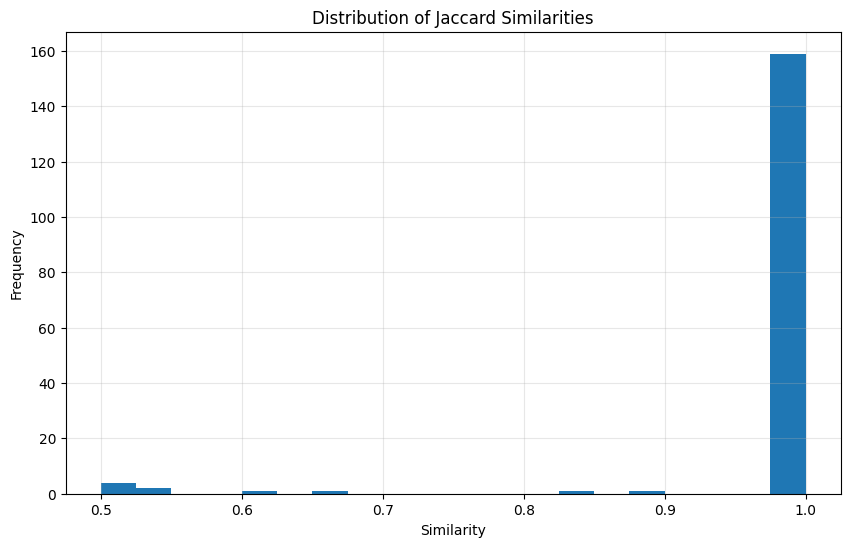


Examples of Similar Reviews:

Similar Pair 1 (Similarity: 1.0000):
Review 1: The story, the language, the imagery - together make a masterpiece.
Review 2: The story, the language, the imagery - together make a masterpiece.
--------------------------------------------------------------------------------

Similar Pair 2 (Similarity: 1.0000):
Review 1: &quot;To prolong doubt was to prolong hope.&quot; - Jane EyreHow true! This book displays an almost unusual scenario. An orphan thrown into a tumultuous life and endures to find a man above her social...
Review 2: &quot;To prolong doubt was to prolong hope.&quot; - Jane EyreHow true! This book displays an almost unusual scenario. An orphan thrown into a tumultuous life and endures to find a man above her social...
--------------------------------------------------------------------------------

Similar Pair 3 (Similarity: 1.0000):
Review 1: I would recomend this book for 6th grade and up. I give this book two thumbs up.The book is about a 

In [7]:
#analyze similarity distribution
plt.figure(figsize=(10, 6))
plt.hist(similar_reviews_df['similarity'], bins=20)
plt.title('Distribution of Jaccard Similarities')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

#display examples of similar reviews
print("\nExamples of Similar Reviews:")
for i, (_, pair) in enumerate(similar_reviews_df.sort_values('similarity', ascending=False).head(5).iterrows()):
    review1_id = pair['review1_id']
    review2_id = pair['review2_id']

    review1 = df_sample.loc[review1_id]['review/text']
    review2 = df_sample.loc[review2_id]['review/text']

    print(f"\nSimilar Pair {i+1} (Similarity: {pair['similarity']:.4f}):")
    print(f"Review 1: {review1[:200]}..." if len(review1) > 200 else f"Review 1: {review1}")
    print(f"Review 2: {review2[:200]}..." if len(review2) > 200 else f"Review 2: {review2}")
    print("-" * 80)

#save the results
similar_reviews_df.to_csv('similar_reviews.csv', index=False)
print("Results saved to 'similar_reviews.csv'")

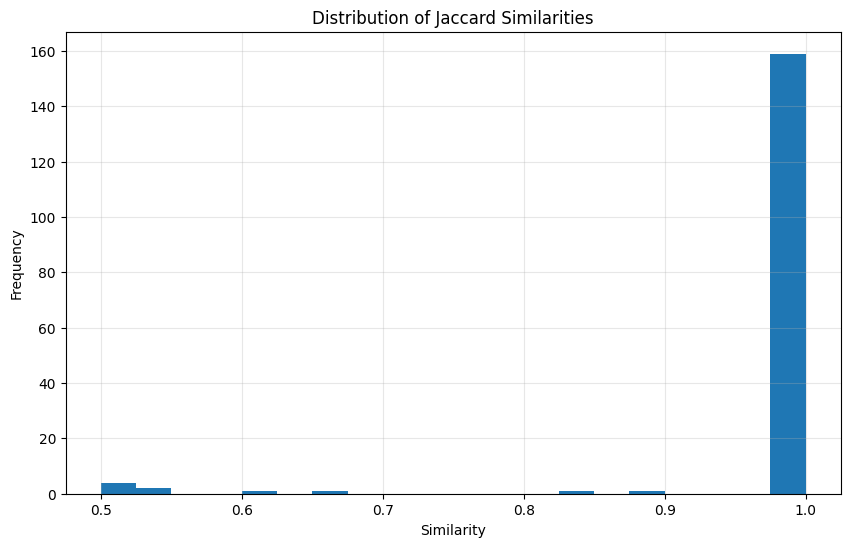


Examples of Partially Similar Reviews (similarity < 1.0):

Similar Pair 1 (Similarity: 0.8750):
Review 1: I haven't had time to read this book yet, but I reviewed it and it is the version I wanted.
Review 2: I haven't had time to read this book, but I have reviewed it & it is the version I wanted.
--------------------------------------------------------------------------------

Similar Pair 2 (Similarity: 0.8421):
Review 1: I am going to refer to the original text version written by Adam Smith: This was absolutely a brutal read; however, it was more or less a paradox described as painfully interesting. The mind of Adam S...
Review 2: This was absolutely a brutal read; however, it was more or less a paradox described as painfully interesting. The mind of Adam Smith is incredible, and I encourage an interested reader to duke it out ...
--------------------------------------------------------------------------------

Similar Pair 3 (Similarity: 0.6667):
Review 1: I bought them (Northange

In [8]:
#analyze similarity distribution
plt.figure(figsize=(10, 6))
plt.hist(similar_reviews_df['similarity'], bins=20)
plt.title('Distribution of Jaccard Similarities')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

#filter for reviews with similarity < 1 but above threshold
filtered_reviews = similar_reviews_df[(similar_reviews_df['similarity'] < 1.0)]

#display examples of these partially similar reviews
print(f"\nExamples of Partially Similar Reviews (similarity < 1.0):")
for i, (_, pair) in enumerate(filtered_reviews.sort_values('similarity', ascending=False).head(5).iterrows()):
    review1_id = pair['review1_id']
    review2_id = pair['review2_id']

    review1 = df_sample.loc[review1_id]['review/text']
    review2 = df_sample.loc[review2_id]['review/text']

    print(f"\nSimilar Pair {i+1} (Similarity: {pair['similarity']:.4f}):")
    print(f"Review 1: {review1[:200]}..." if len(review1) > 200 else f"Review 1: {review1}")
    print(f"Review 2: {review2[:200]}..." if len(review2) > 200 else f"Review 2: {review2}")
    print("-" * 80)

#save the filtered results
filtered_reviews.to_csv('partially_similar_reviews.csv', index=False)
print("Results saved to 'partially_similar_reviews.csv'")

In [9]:
from IPython.display import HTML, display
import ipywidgets as widgets

def show_similar_reviews(similarity_threshold):
    filtered = similar_reviews_df[similar_reviews_df['similarity'] >= similarity_threshold]
    print(f"Found {len(filtered)} pairs with similarity >= {similarity_threshold}")

    if len(filtered) > 0:
        pair = filtered.iloc[0]
        review1_id = pair['review1_id']
        review2_id = pair['review2_id']

        review1 = df_sample.loc[review1_id]['review/text']
        review2 = df_sample.loc[review2_id]['review/text']

        print(f"Similarity: {pair['similarity']:.4f}")
        print(f"Review 1: {review1}")
        print(f"Review 2: {review2}")

#create a slider for threshold
slider = widgets.FloatSlider(
    value=0.5,
    min=0.1,
    max=0.9,
    step=0.05,
    description='Threshold:',
    continuous_update=False
)

#connect the slider to the function
widgets.interact(show_similar_reviews, similarity_threshold=slider)

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=0.9, min=0…

<function __main__.show_similar_reviews(similarity_threshold)>

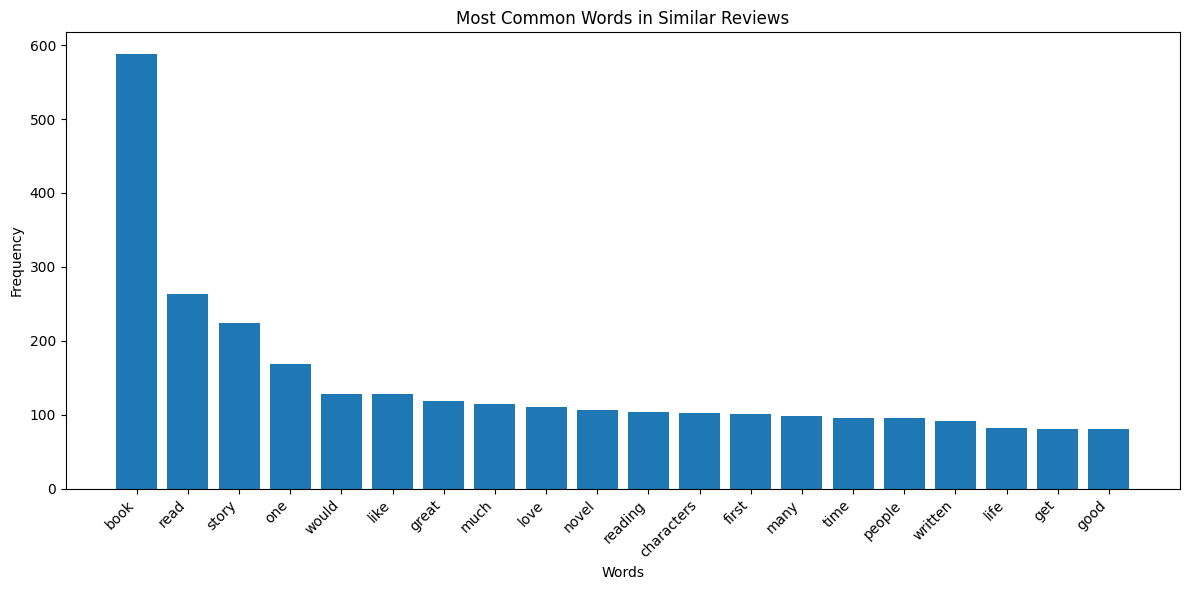

In [10]:
#analyze most common words in similar reviews
from collections import Counter

all_tokens = []
for _, pair in similar_reviews_df.iterrows():
    review1_id = pair['review1_id']
    review2_id = pair['review2_id']

    tokens1 = df_sample.loc[review1_id]['processed_tokens']
    tokens2 = df_sample.loc[review2_id]['processed_tokens']

    all_tokens.extend(tokens1)
    all_tokens.extend(tokens2)

#count most common tokens
token_counts = Counter(all_tokens)
common_tokens = token_counts.most_common(20)

#plot most common tokens
plt.figure(figsize=(12, 6))
words, counts = zip(*common_tokens)
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Most Common Words in Similar Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

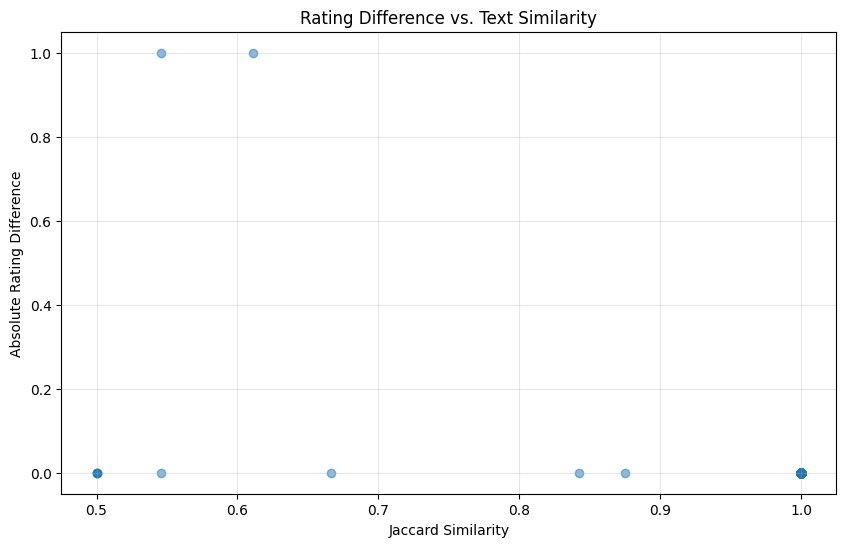

In [11]:
#assuming the dataset has a 'review/score' column
rating_data = []
for _, pair in similar_reviews_df.iterrows():
    review1_id = pair['review1_id']
    review2_id = pair['review2_id']

    #get ratings for both reviews
    rating1 = df_sample.loc[review1_id]['review/score']
    rating2 = df_sample.loc[review2_id]['review/score']

    rating_data.append({
        'similarity': pair['similarity'],
        'rating1': rating1,
        'rating2': rating2,
        'rating_diff': abs(rating1 - rating2)
    })

rating_df = pd.DataFrame(rating_data)

plt.figure(figsize=(10, 6))
plt.scatter(rating_df['similarity'], rating_df['rating_diff'], alpha=0.5)
plt.title('Rating Difference vs. Text Similarity')
plt.xlabel('Jaccard Similarity')
plt.ylabel('Absolute Rating Difference')
plt.grid(alpha=0.3)
plt.show()

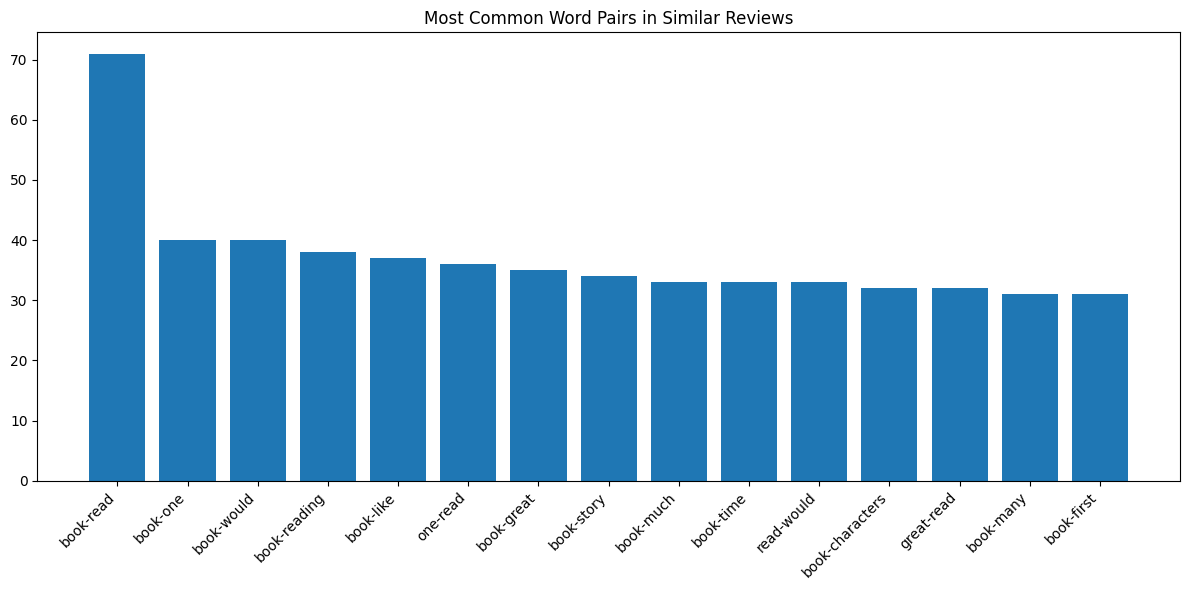

In [12]:
from collections import Counter
import itertools

word_pairs = []
for _, pair in similar_reviews_df.iterrows():
    review1_id = pair['review1_id']
    review2_id = pair['review2_id']

    #get intersection of tokens from both reviews
    common_tokens = set(df_sample.loc[review1_id]['processed_tokens']) & set(df_sample.loc[review2_id]['processed_tokens'])

    #create pairs of words that appear together
    if len(common_tokens) > 1:
        pairs = list(itertools.combinations(sorted(common_tokens), 2))
        word_pairs.extend(pairs)

#count and display most common word pairs
pair_counts = Counter(word_pairs)
top_pairs = pair_counts.most_common(15)

plt.figure(figsize=(12, 6))
labels = [f"{pair[0][0]}-{pair[0][1]}" for pair in top_pairs]
values = [pair[1] for pair in top_pairs]
plt.bar(labels, values)
plt.xticks(rotation=45, ha='right')
plt.title('Most Common Word Pairs in Similar Reviews')
plt.tight_layout()
plt.show()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

#extract common words from similar review pairs
common_words_by_pair = []
for _, pair in similar_reviews_df.iterrows():
    review1_id = pair['review1_id']
    review2_id = pair['review2_id']

    common_tokens = set(df_sample.loc[review1_id]['processed_tokens']) & set(df_sample.loc[review2_id]['processed_tokens'])
    common_words_by_pair.append(' '.join(common_tokens))

#create TF-IDF matrix
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(common_words_by_pair)

#cluster the reviews
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

#get top words for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

# Display clusters
for i in range(num_clusters):
    print(f"Cluster {i}:")
    cluster_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Top terms: {', '.join(cluster_terms)}")
    print("-" * 40)

Cluster 0:
Top terms: book, life, one, read, much, like, characters, love, see, many
----------------------------------------
Cluster 1:
Top terms: book, excellent, great, read, reading, classic, recommend, put, books, better
----------------------------------------
Cluster 2:
Top terms: looking, book, good, read, want, stupid, history, havent, way, well
----------------------------------------
Cluster 3:
Top terms: good, read, book, really, time, great, fun, glad, reading, thought
----------------------------------------
Cluster 4:
Top terms: bookshelf, digital, space, easy, perfect, take, use, always, books, flowers
----------------------------------------


=== SIMILARITY THRESHOLD EVALUATION ===
   threshold  num_pairs  avg_similarity  max_similarity  min_similarity  \
0        0.1        169        0.976839             1.0        0.500000   
1        0.2        169        0.976839             1.0        0.500000   
2        0.3        169        0.976839             1.0        0.500000   
3        0.4        169        0.976839             1.0        0.500000   
4        0.5        169        0.976839             1.0        0.500000   
5        0.6        163        0.993834             1.0        0.611111   
6        0.7        161        0.998243             1.0        0.842105   
7        0.8        161        0.998243             1.0        0.842105   
8        0.9        159        1.000000             1.0        1.000000   

   std_similarity  
0        0.098364  
1        0.098364  
2        0.098364  
3        0.098364  
4        0.098364  
5        0.042796  
6        0.015823  
7        0.015823  
8        0.000000  


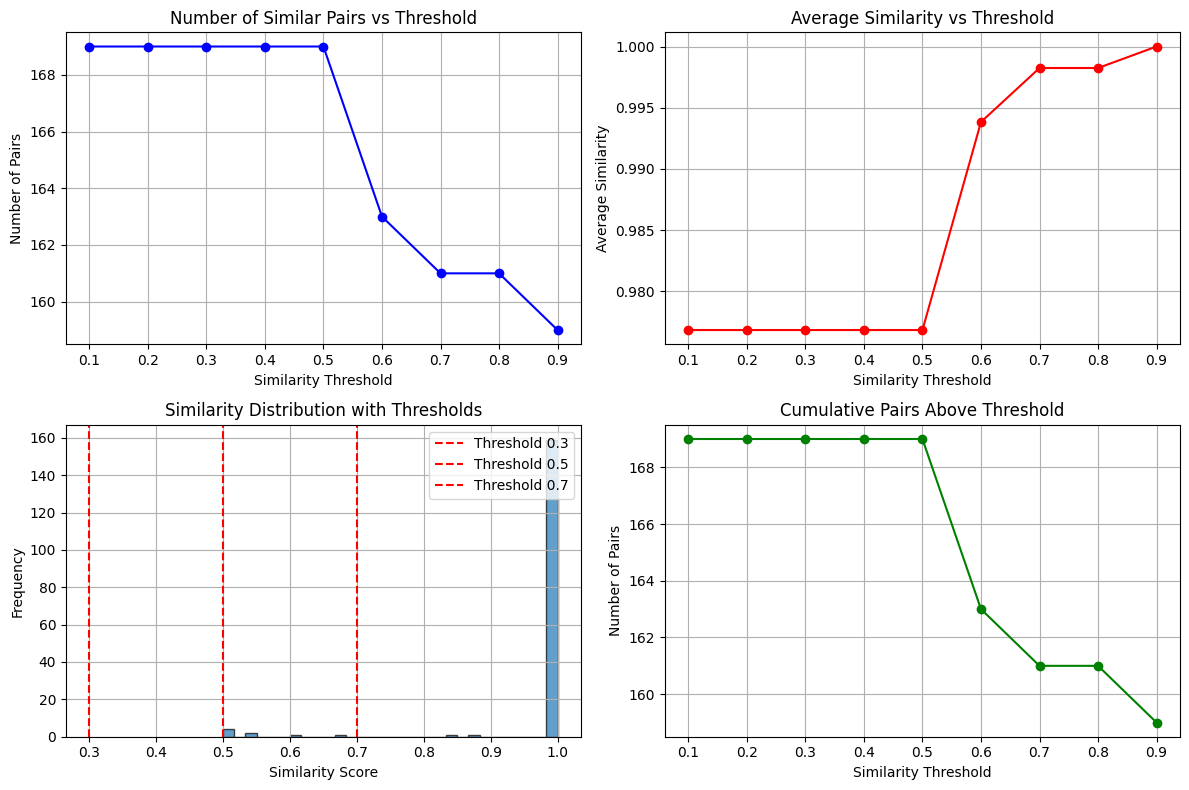


COMPREHENSIVE SIMILARITY DETECTION SUMMARY

Dataset Statistics:
------------------
  Total reviews processed: 20000
  Reviews with sufficient tokens: 19913
  Total possible pairs: 199990000

Similarity Detection Results:
----------------------------
  Similar pairs found: 169
  Percentage of similar pairs: 0.0001%
  Average similarity score: 0.9768
  Median similarity score: 1.0000
  Similarity score range: 0.5000 - 1.0000
  Standard deviation: 0.0984

Quality Metrics:
---------------
  Pairs with similarity > 0.7: 161
  Pairs with similarity > 0.8: 161
  Pairs with similarity > 0.9: 159
  Perfect matches (similarity = 1.0): 159

ALGORITHM PERFORMANCE ANALYSIS
Brute force would require: 199,990,000 comparisons
LSH reduced this to approximately: 169 similarity calculations
Reduction factor: 1183372.78x

Memory efficiency:
  MinHash objects created: 19,913
  MinHash parameters: 128 permutations
  LSH threshold: 0.5

Comprehensive analysis saved to 'similarity_analysis_report.json'


In [14]:
def evaluate_similarity_thresholds():
    """Evaluate how different similarity thresholds affect results"""
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    results = []

    for threshold in thresholds:
        pairs = similar_reviews_df[similar_reviews_df['similarity'] >= threshold]
        if len(pairs) > 0:
            results.append({
                'threshold': threshold,
                'num_pairs': len(pairs),
                'avg_similarity': pairs['similarity'].mean(),
                'max_similarity': pairs['similarity'].max(),
                'min_similarity': pairs['similarity'].min(),
                'std_similarity': pairs['similarity'].std()
            })
        else:
            results.append({
                'threshold': threshold,
                'num_pairs': 0,
                'avg_similarity': 0,
                'max_similarity': 0,
                'min_similarity': 0,
                'std_similarity': 0
            })

    eval_df = pd.DataFrame(results)
    return eval_df

#run the evaluation
print("=== SIMILARITY THRESHOLD EVALUATION ===")
threshold_eval = evaluate_similarity_thresholds()
print(threshold_eval)

#visualize threshold impact
plt.figure(figsize=(12, 8))

#plot 1: Number of pairs vs threshold
plt.subplot(2, 2, 1)
plt.plot(threshold_eval['threshold'], threshold_eval['num_pairs'], 'bo-')
plt.title('Number of Similar Pairs vs Threshold')
plt.xlabel('Similarity Threshold')
plt.ylabel('Number of Pairs')
plt.grid(True)

#plot 2: Average similarity vs threshold
plt.subplot(2, 2, 2)
plt.plot(threshold_eval['threshold'], threshold_eval['avg_similarity'], 'ro-')
plt.title('Average Similarity vs Threshold')
plt.xlabel('Similarity Threshold')
plt.ylabel('Average Similarity')
plt.grid(True)

#plot 3: Distribution analysis
plt.subplot(2, 2, 3)
plt.hist(similar_reviews_df['similarity'], bins=30, alpha=0.7, edgecolor='black')
for threshold in [0.3, 0.5, 0.7]:
    plt.axvline(x=threshold, color='red', linestyle='--',
                label=f'Threshold {threshold}')
plt.title('Similarity Distribution with Thresholds')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

#plot 4: Cumulative pairs
plt.subplot(2, 2, 4)
cumulative_pairs = []
for threshold in threshold_eval['threshold']:
    pairs_above = len(similar_reviews_df[similar_reviews_df['similarity'] >= threshold])
    cumulative_pairs.append(pairs_above)

plt.plot(threshold_eval['threshold'], cumulative_pairs, 'go-')
plt.title('Cumulative Pairs Above Threshold')
plt.xlabel('Similarity Threshold')
plt.ylabel('Number of Pairs')
plt.grid(True)

plt.tight_layout()
plt.show()

#generate summary statistics
def generate_detailed_summary():
    """Generate comprehensive summary of the similarity detection results"""

    total_possible_pairs = len(df_sample) * (len(df_sample) - 1) // 2

    summary = {
        'Dataset Statistics': {
            'Total reviews processed': len(df_sample),
            'Reviews with sufficient tokens': len([idx for idx in minhashes.keys()]),
            'Total possible pairs': total_possible_pairs,
        },
        'Similarity Detection Results': {
            'Similar pairs found': len(similar_reviews_df),
            'Percentage of similar pairs': f"{len(similar_reviews_df)/total_possible_pairs*100:.4f}%",
            'Average similarity score': f"{similar_reviews_df['similarity'].mean():.4f}",
            'Median similarity score': f"{similar_reviews_df['similarity'].median():.4f}",
            'Similarity score range': f"{similar_reviews_df['similarity'].min():.4f} - {similar_reviews_df['similarity'].max():.4f}",
            'Standard deviation': f"{similar_reviews_df['similarity'].std():.4f}",
        },
        'Quality Metrics': {
            'Pairs with similarity > 0.7': len(similar_reviews_df[similar_reviews_df['similarity'] > 0.7]),
            'Pairs with similarity > 0.8': len(similar_reviews_df[similar_reviews_df['similarity'] > 0.8]),
            'Pairs with similarity > 0.9': len(similar_reviews_df[similar_reviews_df['similarity'] > 0.9]),
            'Perfect matches (similarity = 1.0)': len(similar_reviews_df[similar_reviews_df['similarity'] == 1.0]),
        }
    }

    return summary

#generate and display summary
print("\n" + "="*50)
print("COMPREHENSIVE SIMILARITY DETECTION SUMMARY")
print("="*50)

summary = generate_detailed_summary()
for category, metrics in summary.items():
    print(f"\n{category}:")
    print("-" * len(category))
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

#performance analysis
def analyze_algorithm_performance():
    """Analyze the performance characteristics of the similarity detection"""

    print(f"\n{'='*50}")
    print("ALGORITHM PERFORMANCE ANALYSIS")
    print("="*50)

    #LSH effectiveness
    total_comparisons_brute_force = len(df_sample) * (len(df_sample) - 1) // 2
    actual_comparisons = len(similar_reviews_df)  # This is an approximation

    print(f"Brute force would require: {total_comparisons_brute_force:,} comparisons")
    print(f"LSH reduced this to approximately: {actual_comparisons:,} similarity calculations")
    print(f"Reduction factor: {total_comparisons_brute_force/max(actual_comparisons,1):.2f}x")

    #memory efficiency
    print(f"\nMemory efficiency:")
    print(f"  MinHash objects created: {len(minhashes):,}")
    print(f"  MinHash parameters: {num_perm} permutations")
    print(f"  LSH threshold: {similarity_threshold}")

    return {
        'brute_force_comparisons': total_comparisons_brute_force,
        'actual_comparisons': actual_comparisons,
        'reduction_factor': total_comparisons_brute_force/max(actual_comparisons,1)
    }

#run performance analysis
perf_stats = analyze_algorithm_performance()

#save comprehensive results
comprehensive_results = {
    'summary_statistics': summary,
    'threshold_evaluation': threshold_eval.to_dict('records'),
    'performance_stats': perf_stats
}

#save to JSON for future reference
import json
with open('similarity_analysis_report.json', 'w') as f:
    json.dump(comprehensive_results, f, indent=2, default=str)

print(f"\nComprehensive analysis saved to 'similarity_analysis_report.json'")
print("="*50)